## Imports

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import random
import tqdm
import itertools
import collections
from copy import deepcopy
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

## Helper Code

In [2]:
#Auxiliary stuff
def calculate_accuracy(prediction, target):
    """
    To compute mean accuracy between prediction and target
    """
    assert prediction.shape == target.shape
    matching = (prediction == target).float()
    return matching.mean()

class AverageMeter:
    """
    To store running average
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## CIFAR-10 dataset: Data Loading and Preparation

Setup datasets

In [3]:
# Convert from PIL to torch.Tensor normalize each pixel from [0, 255]
# range to [0.0, 1.0]
base_transforms = transforms.ToTensor()

# An augmentation to image horizontally (with a probability equal to 0.5)
# To make model more robust and prevent overfitting
aug_transforms = transforms.RandomHorizontalFlip(p=0.5)

# Gather all transforms together
train_transforms = transforms.Compose([
    base_transforms,
    aug_transforms
])

# Define datasets
train_dataset = datasets.CIFAR10('./', train=True, download=True,
                                 transform=train_transforms)

# test dataset needs to only use base_transforms
test_dataset = datasets.CIFAR10('./', train=False, download=True,
                                transform=base_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 42251594.37it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Random train data visualization

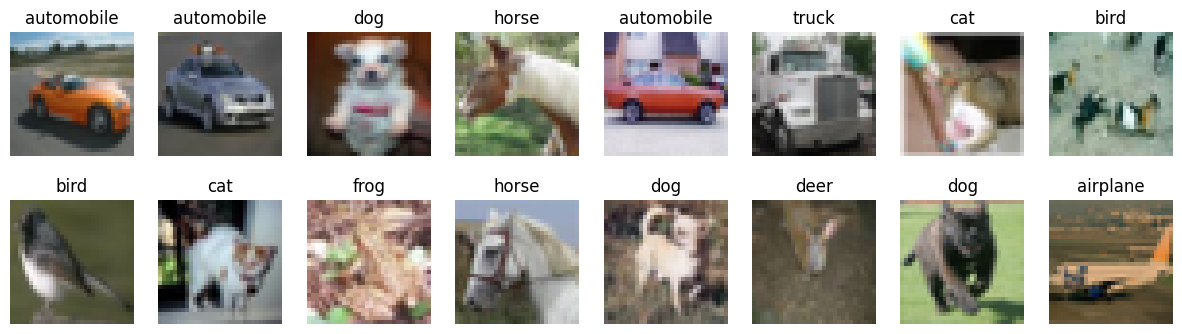

In [4]:
index2class = {v: k for k, v in train_dataset.class_to_idx.items()}

cols = 8
rows = 2

fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        random_index = random.randint(0, len(train_dataset) - 1)

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')

        image, label = train_dataset[random_index]

        # move the channel dimension to the end
        images = image.permute(1, 2, 0)

        ax.imshow(images)
        ax.set_title(index2class[label])

plt.show()

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             num_workers=0, pin_memory=True)

## Model Definition + Training + Save

CNN architecture setup

In [6]:
def make_model():
    """
    Define model architecture.
    """
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
        nn.LeakyReLU(negative_slope = 0.1),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
        nn.LeakyReLU(negative_slope = 0.1),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.25),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
        nn.LeakyReLU(negative_slope = 0.1),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
        nn.LeakyReLU(negative_slope = 0.1),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.25),
        nn.Flatten(),
        nn.Linear(in_features=8*8*64, out_features=256),
        nn.Dropout(p=0.5),
        nn.LeakyReLU(negative_slope = 0.1),
        nn.Linear(in_features=256, out_features=10)
    )
    return model

In [7]:
model = make_model()

Number of parameters in model

In [8]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [9]:
sum(p.numel() for p in model.parameters())

1084234

Training setup

In [10]:
NUM_EPOCH = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device('cuda:0')
HISTORY = collections.defaultdict(list)

model = make_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

# Set up learning rate scheduler
# This will speed up the convergence of the model
lr_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[20, 40],
    gamma=0.1,
    verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-02.


Train and visualize loss, accuracy

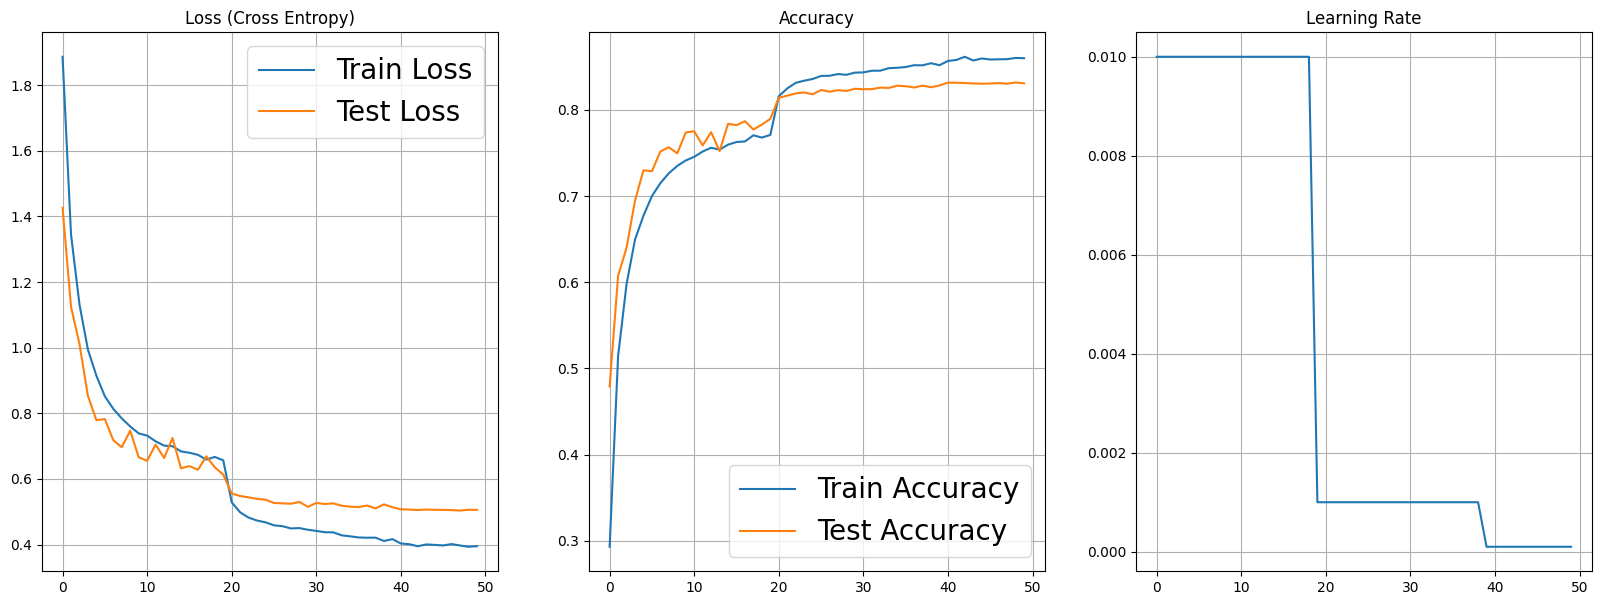

In [11]:
for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()

    # training loop
    # sets the module in training mode -- for nn.Dropout
    model.train()
    # wrap `train_dataloader` within tqdm to visualize progress
    for train_batch in tqdm.tqdm(train_dataloader):
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # do forward pass
        logits = model(images)
        prediction = logits.argmax(dim=-1)

        # calculate loss (CrossEntropy)
        loss = criterion(logits, labels)

        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()

        # calculate new gradients
        loss.backward()

        # do optimization step
        optimizer.step()

        # calculate and current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )

    # update lr_scheduler
    lr_scheduler.step()

    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)

    # lr_scheduler.get_last_lr() return list of LRs (one LR for each group)
    HISTORY['learning_rate'].append(lr_scheduler.get_last_lr()[0])

    # testing loop
    # sets the module in evaluation mode
    model.eval()
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # same as in training loop
            logits = model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)

        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )

    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)

    # visualize dynamically
    display.clear_output()
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)

    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)

    axes[2].set_title('Learning Rate')
    axes[2].plot(HISTORY['learning_rate'])
    axes[2].grid()

    plt.show()


Save model

In [12]:
torch.save(model.state_dict(), 'model_weights.pt')

## Load saved model

Verify saved model

In [13]:
weights = torch.load('model_weights.pt', map_location=DEVICE)
model = make_model().to(DEVICE)
model.load_state_dict(weights)

<All keys matched successfully>

## Model Performance Visualization

Confusion matrix of test predictions

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
ground_truth = []
predictions = []

model.eval()
for test_batch in test_dataloader:
    images, labels = test_batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        logits = model(images)
        prediction = logits.argmax(dim=-1).cpu()

    ground_truth.append(labels.cpu())
    predictions.append(prediction)

# concatenate tensors into one
ground_truth = torch.cat(ground_truth).numpy()
predictions = torch.cat(predictions).numpy()

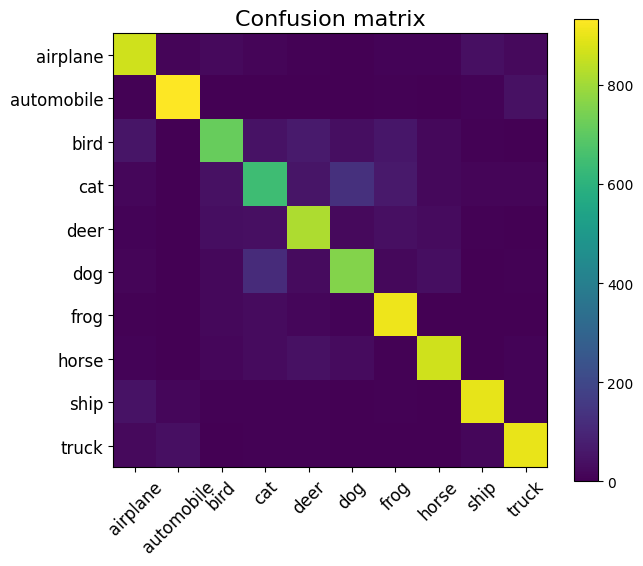

In [16]:
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(
    confusion_matrix(
        ground_truth,
        predictions
    )
)
plt.xticks(np.arange(10), train_dataset.classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), train_dataset.classes, fontsize=12)
plt.colorbar()
plt.show()

Notice how dog-cat pair are kind of confusing - as expected

Accuracy of model

In [17]:
accuracy_score(ground_truth, predictions)

0.8307

Random test data prediction visualization

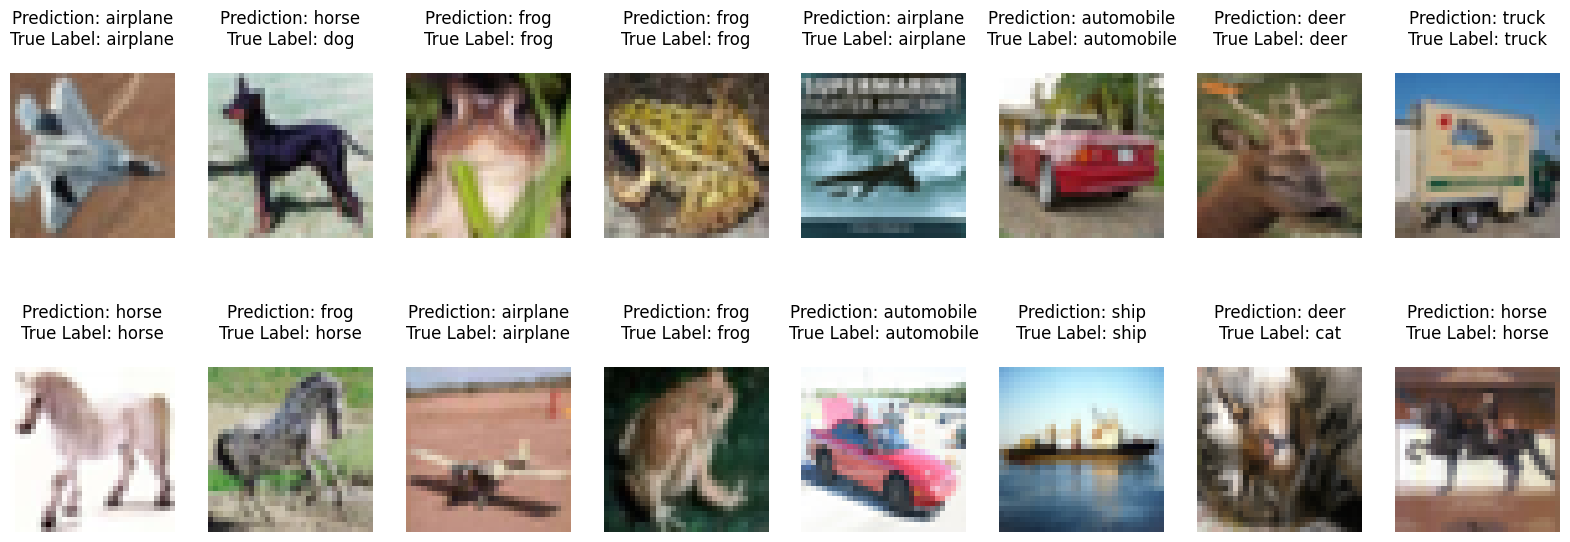

In [18]:
# inspect preditions
fig = plt.figure(figsize=(20, 7))

for i in range(cols):
    for j in range(rows):

        random_index = random.randint(0, len(test_dataset) - 1)

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')

        image, label = test_dataset[random_index]

        # move the channel dimension to the end
        images = image.permute(1, 2, 0)

        ax.imshow(images)
        ax.set_title(f"Prediction: {index2class[predictions[random_index].item()]}\n"
                     f"True Label: {index2class[label]}\n")
plt.show()

## Generating images giving max stimuli

In [19]:
# freeze model weights
def freeze_weights(model):
    for p in model.parameters():
        p.requires_grad_(False)

def image2rgb(image):
    # normalize image so that mean is 0 and std 0.25
    eps = 1e-7
    x_norm = 0.25 * (image - image.mean())/(image.std() + eps)
    # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
    x = (x_norm + 0.5) * 255

    # clip values to [0, 255] and convert to bytes
    x = torch.clamp(x, 0, 255) \
        .squeeze(0) \
        .permute(1, 2, 0) \
        .byte()

    return x

def find_maximum_stimuli(
    model: nn.Module,
    layer_index: int,
    filter_index: int,
    step_size: float = 0.1,
    input_size: list = (32, 32),
    iterations: int = 1,
    verbose: bool = True
):
    layer = model[layer_index]

    if get_num_parameters(layer) == 0:
        raise ValueError(f"{layer} don't have trainable parameters!")

    is_conv = True if isinstance(layer, nn.Conv2d) else False

    new_model = model[:layer_index + 1]
    freeze_weights(new_model)

    # sample random noise image from Uniform[0, 1]
    image = torch.rand(1, 3, *input_size).to(DEVICE)
    image = (image - 0.5) * (0.1 if is_conv else 0.001)

    # ensure gradient will be computed
    image.requires_grad_(True)

    # gradient ascent
    for i in range(iterations):
        feature_map = new_model(image)
        # measure of activation from the filter index to be maximized
        loss = feature_map[:, filter_index].mean()
        # calculate gradients
        loss.backward()
        # get image gradient
        grad = image.grad
        # update current image (weights)
        with torch.no_grad():
            image += step_size * (grad / (torch.norm(grad) + 1e-10))
        # zero out current grad
        grad.zero_()

        if verbose:
            print(f'Current loss: {loss}')

        # decode image
        rgbimg = image2rgb(image.detach()).cpu()

    return rgbimg, loss.detach().cpu()

In [20]:
def plot_filters_stimuli(
    model: nn.Module,
    layer_index: int,
    iterations=20,
    step_size=1.,
    verbose=False
):
    cols = 8
    rows = 8
    filter_index = 0

    # expecting that `model[layer_index]` is nn.Conv or nn.Linear
    max_filter_index = model[layer_index].weight.shape[0] - 1

    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1), dpi=100)

    for i in range(cols):
        for j in range(rows):

            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20

                stimuli, loss = find_maximum_stimuli(
                        model=model,
                        layer_index=layer_index,
                        filter_index=filter_index,
                        step_size=step_size,
                        iterations=iterations,
                        verbose=verbose
                )

                filter_index += 1

                ax.imshow(stimuli)
                ax.set_title("Filter #{}".format(filter_index))

    plt.show()

Generate images giving max stimuli for conv layers:

Layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 0


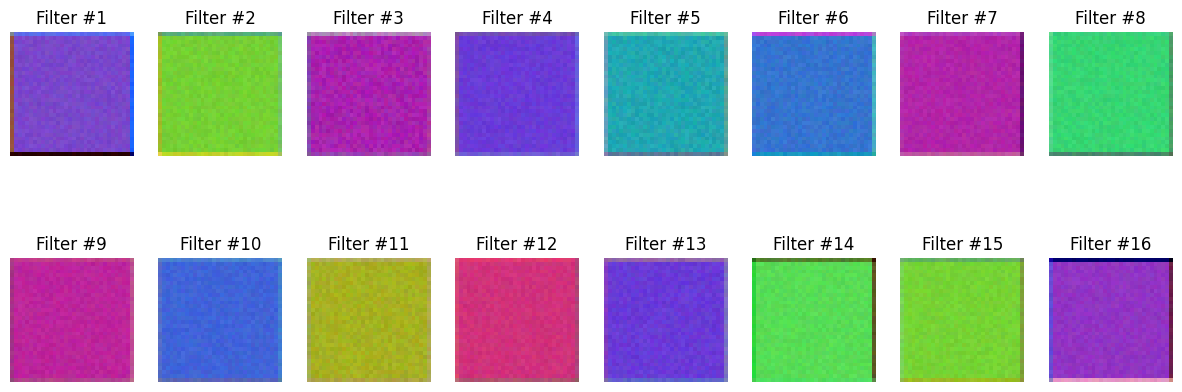

Layer: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 2


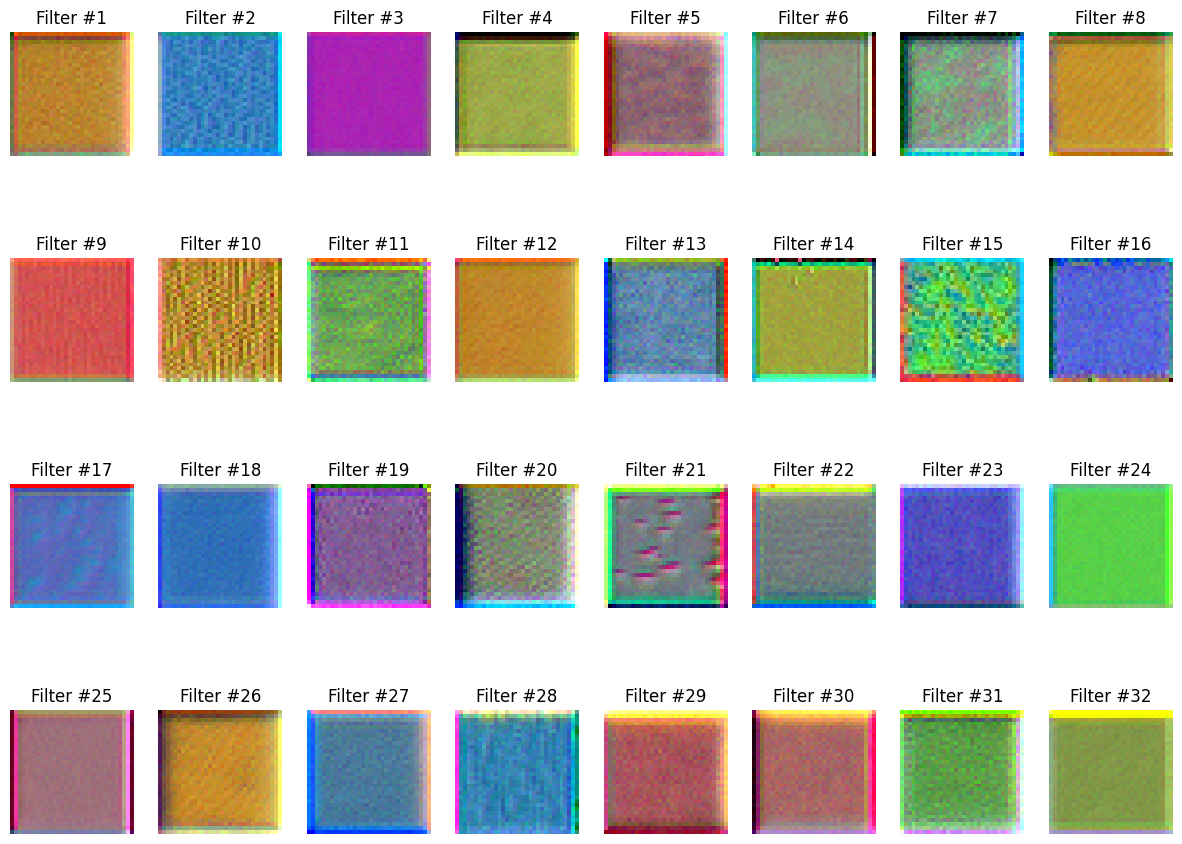

Layer: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 6


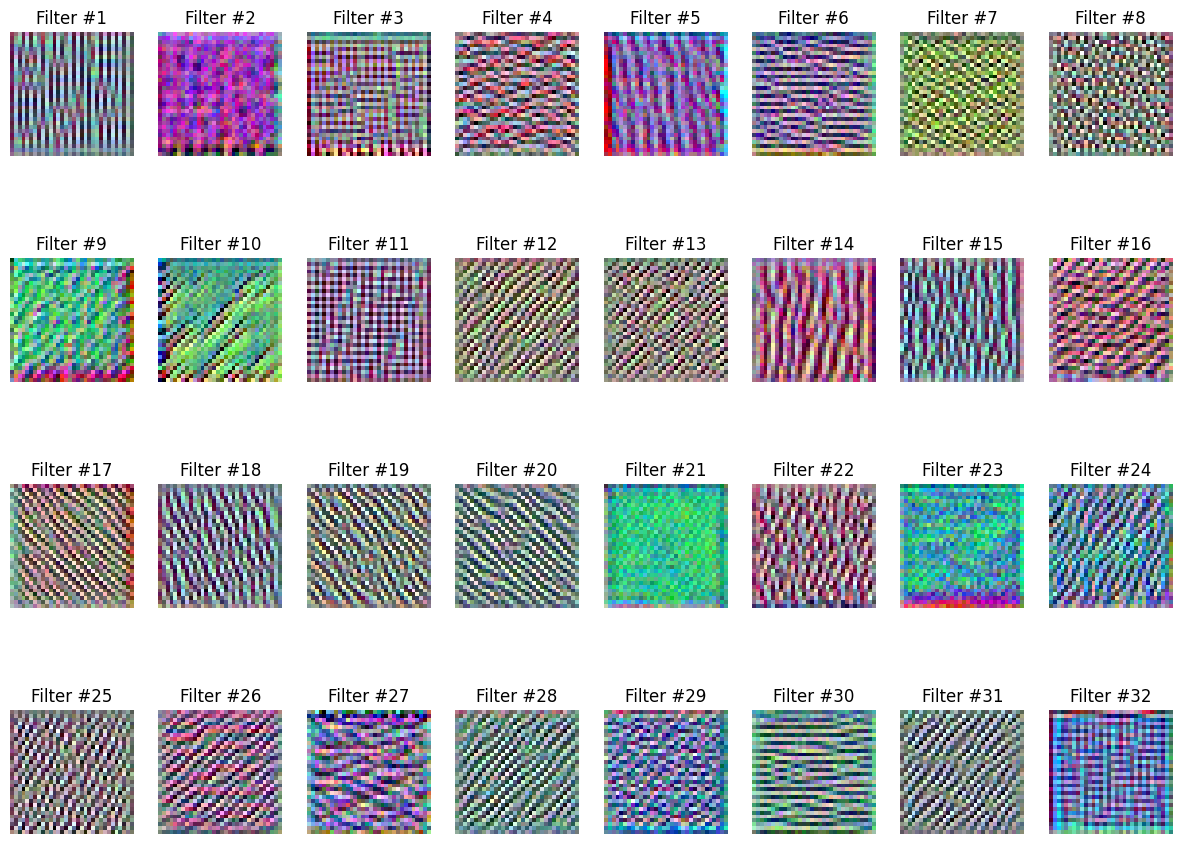

Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Index Layer: 8


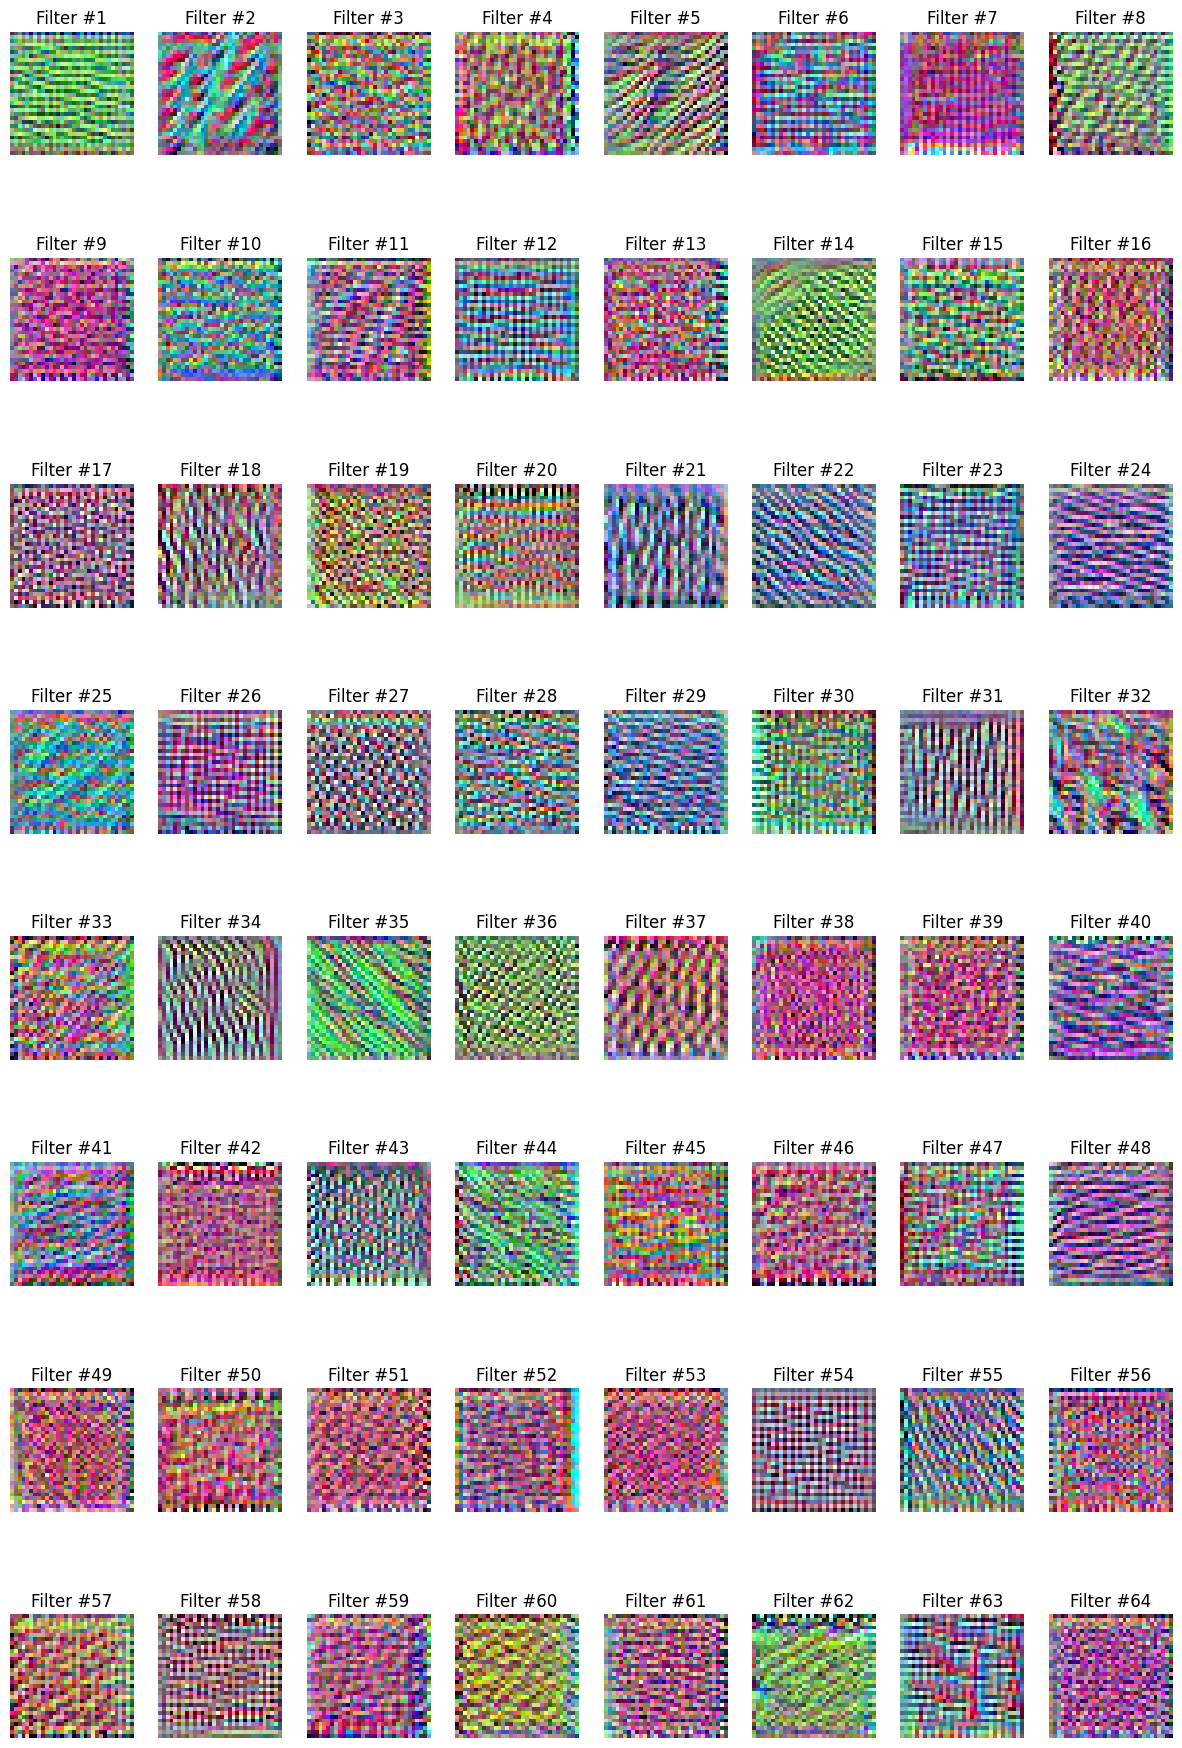

In [21]:
for index_layer, layer in enumerate(model.children()):
    if isinstance(layer, nn.Conv2d):
        print(
            f'Layer: {layer}\n'
            f'Index Layer: {index_layer}'
        )
        plot_filters_stimuli(model, index_layer)

The above images for the conv layers are not discernible in terms of what it is learning.

Generate images giving max stimuli in the final linear layer:

In [22]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


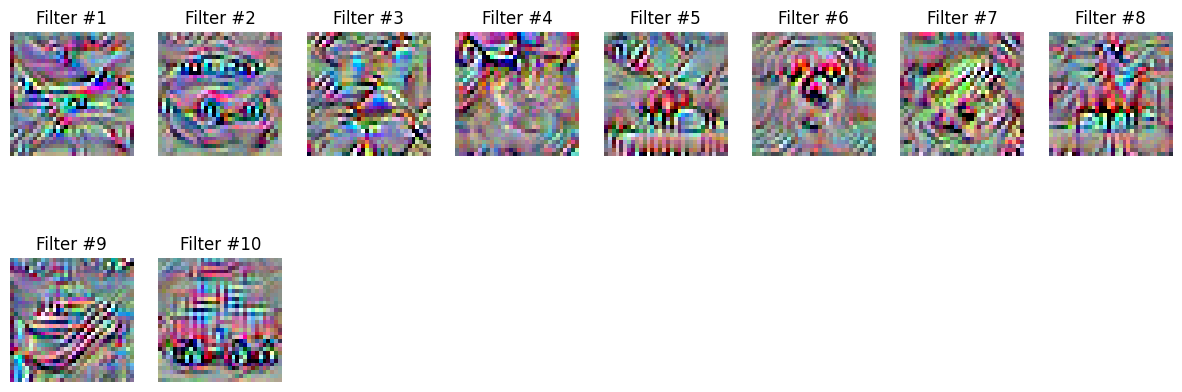

In [23]:
plot_filters_stimuli(
    model,
    layer_index=16,
    iterations=500,
    step_size=0.1,
)

The images giving maximum stimuli very very very slightly resemble the class it represents!!